In [185]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from scipy.spatial.distance import cdist
from fiona.crs import from_epsg
import geopandas as gpd
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [98]:
gs=gpd.GeoDataFrame.from_file("/nfshome"+"/cl4855"+"/ADS"+"/How-greenspace-makes-the-green"+"/Green Spaces"+"/geo_export_082cf1b6-52ed-40bb-9b52-13945bdb1f98.shp")

In [99]:
gs.head()

,feat_code,landuse,park_name,parknum,shape_area,shape_leng,source_id,status,sub_code,system,geometry
0,4910.0,Community Park,Commodore Barry Park,B021,41539.801363,829.420107,2.149100e+10,Updated,491050.0,None,POLYGON ((-73.97922375065221 40.69799879369959...
1,4980.0,Neighborhood Park,Pierrepont Playground,B222,21960.494920,607.555193,2.149800e+10,Unchanged,498000.0,None,POLYGON ((-73.99732028095745 40.69600764072165...
2,4980.0,Neighborhood Park,Cobble Hill Park,B326,28079.076265,784.421990,2.149800e+10,Unchanged,498000.0,None,POLYGON ((-73.99557419919979 40.68792918280799...
3,4980.0,Community Park,Commodore Barry Park,B021,438416.114511,2672.710150,2.149800e+10,Unchanged,498000.0,None,POLYGON ((-73.97746661925957 40.69650941986475...
4,4980.0,Triangle/Plaza,Brooklyn Heights Promenade,B223DG,14465.699799,1376.106398,2.149800e+10,Unchanged,498000.0,None,POLYGON ((-73.99746719287955 40.69692380834881...


In [100]:
green=gs[['park_name','geometry']]

In [101]:
green=green.dissolve(by='park_name')

In [102]:
dog=pd.read_json('DPR_DogRuns_001.json')
bbq=pd.read_json('DPR_Barbecue_001.json')
basket=pd.read_json('DPR_Basketball_001.json')
eat=pd.read_json('DPR_Eateries_001.json')
plg=pd.read_json('DPR_Playgrounds_001.json')
ten=pd.read_json('DPR_Tennis_001.json')
skt=pd.read_json('DPR_IceSkating_001.json')

In [103]:
ten['facility']='Tennis'
bbq['facility']='Barbecue'
dog['facility']='Dogfriend'
basket['facility']='Basketball'
eat['facility']='Eateries'
plg['facility']='Playground'
skt['facility']='skate'

In [104]:
bbq=bbq[['Prop_ID','facility']]
ten=ten[['Prop_ID','facility']]
dog=dog[['Prop_ID','facility']]
basket=basket[['Prop_ID','facility']]
eat=eat[['park_id','facility']]
plg=plg[['Prop_ID','facility']]
skt=skt[['Prop_ID','facility']]

In [105]:
eat=pd.DataFrame(eat)

In [106]:
eat.rename(columns={'park_id':'Prop_ID'},inplace=True)

In [107]:
facility=pd.concat([bbq,ten,dog,basket,eat,plg,skt])

In [108]:
df=pd.DataFrame(facility.groupby(['Prop_ID','facility']).size().reset_index())

In [109]:
facility=pd.pivot_table(df,index='Prop_ID',columns='facility',values=0,fill_value=0)

In [110]:
facility=facility.reset_index()

In [111]:
facility=facility.iloc[1:]

In [112]:
greenspace=gpd.GeoDataFrame(gs[['parknum','geometry']])
greenspace = greenspace.dissolve(by='parknum')
greenspace=greenspace.reset_index()
facilitygs=facility.merge(greenspace,left_on='Prop_ID',right_on="parknum")

In [113]:
facilitygs.head()

,Prop_ID,Barbecue,Basketball,Dogfriend,Eateries,Playground,Tennis,skate,parknum,geometry
0,B001,0,1,0,0,1,0,0,B001,POLYGON ((-73.95819910692008 40.72846909429816...
1,B007,0,1,0,0,1,1,0,B007,(POLYGON ((-74.00191712205063 40.5944044883299...
2,B008,0,1,0,0,1,0,0,B008,(POLYGON ((-73.91136560837775 40.6638884536345...
3,B012,0,1,1,0,2,0,0,B012,POLYGON ((-73.94195616711707 40.67311713865221...
4,B016,0,1,0,1,2,0,0,B016,POLYGON ((-73.92396891415979 40.70211749600103...


In [114]:
facilitygs['area'] = facilitygs['geometry'].apply(lambda x: (x.area * 111**2))

In [115]:
greenname=gs[['parknum','park_name']]
greenname=greenname.drop_duplicates()

In [116]:
gsfacility=facilitygs.merge(greenname,on="parknum",how="inner")

In [117]:
gsfacility.head()

,Prop_ID,Barbecue,Basketball,Dogfriend,Eateries,Playground,Tennis,skate,parknum,geometry,area,park_name
0,B001,0,1,0,0,1,0,0,B001,POLYGON ((-73.95819910692008 40.72846909429816...,0.004740,American Playground
1,B007,0,1,0,0,1,1,0,B007,(POLYGON ((-74.00191712205063 40.5944044883299...,0.091409,Bensonhurst Park
2,B008,0,1,0,0,1,0,0,B008,(POLYGON ((-73.91136560837775 40.6638884536345...,0.057211,Betsy Head Park
3,B008,0,1,0,0,1,0,0,B008,(POLYGON ((-73.91136560837775 40.6638884536345...,0.057211,Betsy Head
4,B008,0,1,0,0,1,0,0,B008,(POLYGON ((-73.91136560837775 40.6638884536345...,0.057211,Greenstreet


In [118]:
gsfacility=gpd.GeoDataFrame(gsfacility)

In [119]:
gsfacility.to_file(driver = 'ESRI Shapefile', filename='green_facility')

In [120]:
%run ~/choroplethNYC.py

Usage: choroplathNYC <path to shapefile> <column>

Options:
  -h, --help            show this help message and exit
  -d, --discrete        discrete steps color bar
  -m CMAP, --cmap=CMAP  matplotlib colormap name
  -t TITLE, --title=TITLE
                        title of figure
  -o OUTPUT, --output=OUTPUT
                        output file  (must be pylab compatible extension, e.g.
                        pdf png etc
  --clobber             clobber output file
  --noshow              do not show figure (default)
  --debug               print debug statements


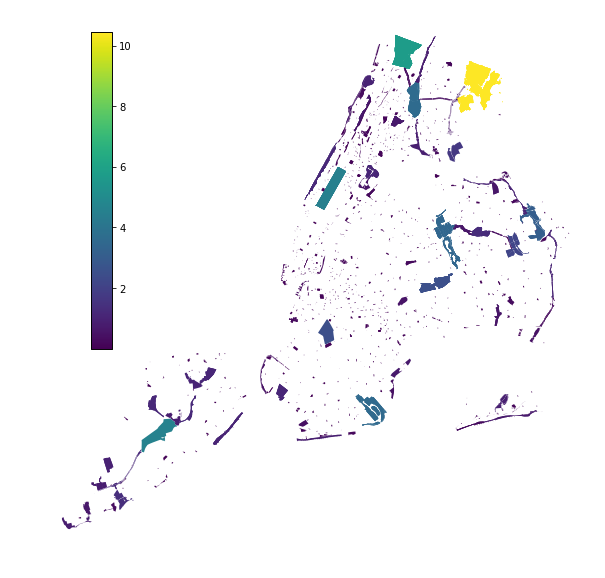

In [189]:
choroplethNYC(gsfacility,column="area",cmap="viridis")
pylab.savefig('parkarea.png')

Figure 1: Chorepleth on the size of area of green space in NYC.

In [122]:
clean=pd.read_csv('Parks_Inspection_Program___Inspections.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13,14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
clean['Round'].describe()

count    102332.000000
mean          3.436735
std           1.732921
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: Round, dtype: float64

In [124]:
clean1=clean[clean['Inspection Year']==2017]

In [125]:
gsfacility.shape

(1105, 12)

In [126]:
clean1=clean1[['Prop ID','Cleanliness']]

In [127]:
clean1=clean1.drop_duplicates(subset='Prop ID', keep="last")

In [128]:
gsclean=gsfacility.merge(clean1,left_on="parknum",right_on="Prop ID",how="inner")

In [129]:
gsclean.shape

(837, 14)

In [130]:
gsclean.columns

Index(['Prop_ID', 'Barbecue', 'Basketball', 'Dogfriend', 'Eateries',
       'Playground', 'Tennis', 'skate', 'parknum', 'geometry', 'area',
       'park_name', 'Prop ID', 'Cleanliness'],
      dtype='object')

In [131]:
gscleanrf=gsclean[['Barbecue', 'Basketball', 'Dogfriend', 'Eateries',
       'Playground', 'Tennis', 'skate', 'area','Cleanliness']]

In [132]:
gscleanrf['Ind']=np.zeros((len(gscleanrf),),dtype=np.int)+1

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [133]:
for i in range(len(gscleanrf)):
    if gscleanrf['Cleanliness'][i]=='A':gscleanrf['Ind'][i]+=1
    if gscleanrf['Cleanliness'][i]=='U':gscleanrf['Ind'][i]+=2

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

In [134]:
np.random.seed(12345)
gscleanrf['index'] = np.random.uniform(low = 0, high = 1, size = len(gscleanrf))
gscleanrf['test'] = pd.get_dummies(gscleanrf['index'] <= 0.3333)[1]

# We don't need the index, so drop it.
del gscleanrf['index']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [135]:
gscleanrftest = gscleanrf[gscleanrf['test'] == 1]
gscleanrftrain = gscleanrf[gscleanrf['test'] == 0]

In [136]:
gscleanrftrain.head()

,Barbecue,Basketball,Dogfriend,Eateries,Playground,Tennis,skate,area,Cleanliness,Ind,test
0,0,1,0,0,1,0,0,0.004740,A,2,0
4,0,1,0,0,1,0,0,0.057211,A,2,0
5,0,1,1,0,2,0,0,0.037705,A,2,0
6,0,1,0,1,2,0,0,0.036870,A,2,0
7,0,0,0,0,1,0,0,0.015399,A,2,0


In [137]:
ytrain = gscleanrftrain['Ind'].as_matrix(columns=None)
ytest = gscleanrftest['Ind'].as_matrix(columns=None)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [138]:
Xtrain=gscleanrftrain[['Barbecue', 'Basketball', 'Dogfriend', 'Eateries',
       'Playground', 'Tennis', 'skate', 'area']].as_matrix(columns=None)
Xtest=gscleanrftest[['Barbecue', 'Basketball', 'Dogfriend', 'Eateries',
       'Playground', 'Tennis', 'skate', 'area']].as_matrix(columns=None)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [139]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(12345)
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

In [140]:
ytrain

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

In [141]:
ypred

array([2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [143]:
cm = confusion_matrix(ytest, ypred)
RFcm = cm
MSE = mean_squared_error(ytest, ypred)

In [144]:
ACC = (cm[0][0] + cm[1][1]) / (len(ypred))

In [145]:
from tabulate import tabulate

In [146]:
table = [[" ","1", "2"],
         ["1", cm[0][0], cm[0][1]], 
         ["2", cm[1][0], cm[1][1]]] 
         
print("The confusion matrix is:")
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print("The Accuracy Rate is", ACC)

The confusion matrix is:
╒═══╤═════╤════╕
│   │  1  │ 2  │
├───┼─────┼────┤
│ 1 │ 212 │ 33 │
├───┼─────┼────┤
│ 2 │ 28  │ 1  │
╘═══╧═════╧════╛
The Accuracy Rate is 0.777372262774


In [186]:
gsfit=smf.ols('Ind ~ Barbecue+Basketball+Dogfriend+Eateries+Playground+Tennis+skate',data=gscleanrf).fit()

In [187]:
gsfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Ind   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9738
Date:                Thu, 13 Dec 2018   Prob (F-statistic):              0.449
Time:                        00:34:25   Log-Likelihood:                -238.90
No. Observations:                 837   AIC:                             493.8
Df Residuals:                     829   BIC:                             531.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0656      0.032     64.091      0.000       2.002       2.129
Barbecue       0.1158      0.076      1.517      0.130      -0.034       0.266
Basketball     0.0229      0.022      1.019      0.308      -0.021       0.067
Dogfriend      0.0308      0.040      0.762      0.446      -0.049       0.110
Eateries       0.0065      0.030      0.217      0.828      -0.053       0.066
Playground     0.0309      0.032      0.975      0.330      -0.031       0.093
Tennis        -0.0505      0.054     -0.935      0.350      -0.157       0.056
skate         -0.0656      0.325     -0.202      0.840      -0.704       0.572
==============================================================================
Omnibus:                      362.692   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1184.632
Skew:                           2.203   Prob(JB):                    5.76e-258
Kurtosis:                       6.814   Cond. No.                         45.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
vals=gsclean[['Barbecue','Basketball','Dogfriend','Eateries','Playground','Tennis','skate']]

In [150]:
valstd = ((vals.T - vals.mean(1)) / vals.std(1)).T

In [156]:
distortions = []
for nc in range(1,10):
    km = KMeans(n_clusters=nc,random_state=444).fit(vals)
    km.fit(vals)
    distortions.append(sum(np.min(cdist(vals, km.cluster_centers_, 'euclidean'), axis=1)) / vals.shape[0])

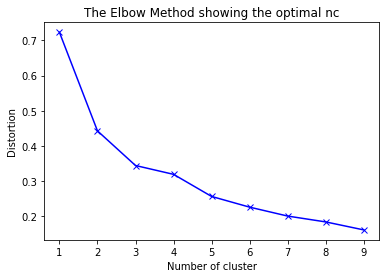

In [194]:
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('Number of cluster')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal nc')
plt.show()
plt.savefig('elbow.png')

Figure 2: Elbow method to find the best cluster number. Here we choose 3.

In [158]:
nc=3
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

In [159]:
kmlabel=pd.DataFrame(km.labels_)

In [175]:
plott=gsfacility.join(kmlabel, how='outer')

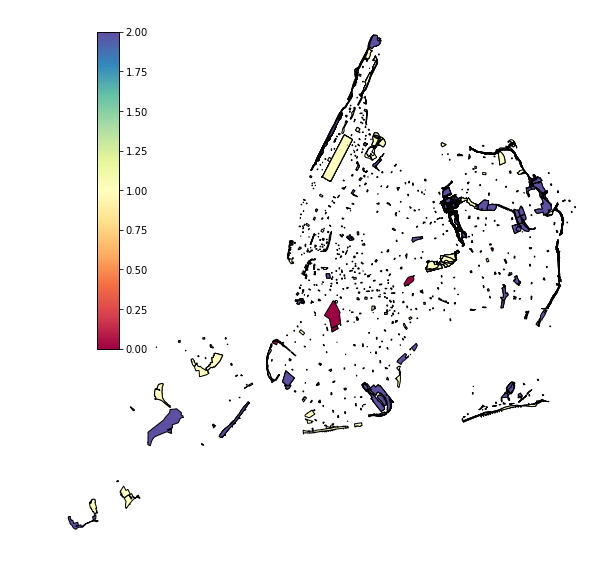

In [192]:
choroplethNYC(plott,column=0,edgecolor='black',cmap="Spectral")
pylab.savefig('cluster.png')

Figure 3: Chorepleth of cluter analysis in NYC of green space.